In [4]:
import json
import os
import random
import time
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.cuda import amp
from torch.autograd import Variable
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
torch.manual_seed(1)
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(device)

cuda:4


In [5]:
os.chdir('/mnt/tapioca/Workspace/hw')

In [6]:
letter_list = ['abcdefghijklmnopqrstuvwxyz']

In [17]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def myOneHot(idx):
    onthot = torch.zeros(1, vocab_size, device=device)
    onthot[0][idx] = 1
    return onthot
def int2word(vec:list):
    word = ''
    for ele in vec:
        letter = letter_list[0][int(ele)-2]
        word += letter
    return word
def print_result(encoder, decoder , detail = False):
    test_data = './dataset/A3_data/test.json'
    new_test_data = './dataset/A3_data/new_test.json'

    for dataset in [test_data, new_test_data]:
        input_list = []
        predict_list, target_list, bleu_list = test(encoder, decoder, dataset)
        test_set = myDataLoader(dataset)
        for test_pair in test_set:
            input_tensor = test_pair[0]
            input_list.append(int2word(input_tensor[:-1]))

        for predict, GT, input in zip(predict_list, target_list, input_list):
            if detail:
                print(f'input:  {input}')
                print(f'target: {GT}')
                print(f'pred:   {predict}')
                print('==================================================')
    print('========================================================')
def show(loss_list, result1, result2):
    plt.tight_layout()
    plt.rcParams['xtick.color'] = 'red'
    plt.rcParams['ytick.color'] = 'red'
    plt.plot(result1)
    plt.show()
    plt.plot(result2)
    plt.show()
    plt.plot(loss_list)
    plt.show()

In [8]:
class myDataLoader(Dataset):
    def __init__(self, data_path):
        super(myDataLoader, self).__init__()
        self.datas_list = []
        self.labels_list = []
        self.EOS_token = 1

        self.letter_list = ['abcdefghijklmnopqrstuvwxyz']
        with open(data_path, 'r') as f:
            train_data = json.load(f)
            # i = 0

            for ele in train_data:
                while ele['input']:
                    input = ele['input'].pop()
                    input_int = self.word2int(input)
                    label_int = self.word2int(ele['target'])
                    self.datas_list.append(input_int)
                    self.labels_list.append(label_int)

                # i += 1
                # if i >= 5: break
    def word2int(self, word:str):
        int_list = []
        for letter in word:
            letter_idx = self.letter_list[0].find(letter)+2
            int_list.append(letter_idx)
        int_list.append(self.EOS_token)
        return int_list

    def __getitem__(self, idex):
        return torch.LongTensor(self.datas_list[idex]).to(device), torch.LongTensor(self.labels_list[idex]).to(device)
    def __len__(self):
        return len(self.datas_list)

In [9]:
class PositionEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model):
        super(PositionEncoding, self).__init__()
        #公式
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        position_encoding = np.array([
            [pos / np.power(10000, 2.0 * (j//2) / self.d_model) for j in range(self.d_model)] for pos in range(self.max_seq_len)])
        #偶數 sin, 奇數 cos
        position_encoding[:, 0::2] = np.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = np.cos(position_encoding[:, 1::2])
        position_encoding = torch.from_numpy(position_encoding)

        self.position_encoding = nn.Embedding(max_seq_len, d_model)
        self.position_encoding.weight = nn.Parameter(position_encoding, requires_grad = False)



In [9]:
# embed=nn.Embedding(28, 512).to(device)
# input = dataset[0][0].view(-1, 1)
# voc_embed_0=embed(input.to(device))
#
#
#
# P = PositionEncoding(28, 512)
# voc_embed_1 = P.position_encoding(input)
# print(voc_embed_0.size())
# print(voc_embed_1.size())
# # print(voc_embed_1[0].size())
#
# # concate 2 vectors
# result=torch.zeros(len(dataset[0][0]), 1,1024)
# t=torch.zeros(1,512,dtype=torch.float64)
#
#
# ans = t.new_tensor(voc_embed_0[0])
# voc_embed_2 = torch.cat((ans, voc_embed_1[0]), 1)
# print(voc_embed_2.size())
# result[0]=voc_embed_2
# print(result.shape)

In [10]:
#Encoder
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_num = 5):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.P = PositionEncoding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.layer_num)


    def forward(self, input, hidden):
        input = input.view(-1, 1)
        word_embedded = self.embedding(input)
        pos_embedded = self.P.position_encoding(input)

        #concate 2 vector
        result = torch.zeros(len(input), 1, self.hidden_size*2)
        t=torch.zeros(1, self.hidden_size, dtype=torch.float64)
        ans = t.new_tensor(word_embedded[0])
        embedded = torch.cat((ans, pos_embedded[0]), 1)
        result[0] = embedded

        output, hidden = self.lstm(word_embedded, hidden)
        return output, hidden

    def initHidden(self):
        h_0 = torch.zeros(self.layer_num, 1, self.hidden_size, device=device)
        c_0 = torch.zeros(self.layer_num, 1, self.hidden_size, device=device)
        return (h_0, c_0)

#Decoder
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, layer_num = 5):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.P = PositionEncoding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.layer_num)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        word_embedded = self.embedding(input).view(1, 1, -1)
        pos_embedded = self.P.position_encoding(input).view(1, 1, -1)

        # #concate 2 vector
        result = torch.zeros(1, 1, self.hidden_size*2)
        t=torch.zeros(1, self.hidden_size, dtype=torch.float64)
        ans = t.new_tensor(word_embedded[0])
        embedded = torch.cat((ans, pos_embedded[0]), 1)

        result[0] = embedded

        output = F.relu(word_embedded)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        #output = F.softmax(output, dim=1)
        return output, hidden

In [19]:
SOS_token = 0
EOS_token = 1
#----------Hyper Parameters----------#
teacher_forcing_ratio = 0.4
LR = 0.01
vocab_size = 29


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, Gscaler, max_length=20):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    #----------sequence to sequence part for encoder----------#
    with amp.autocast():
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)


        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False


        #----------sequence to sequence part for decoder----------#
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)

                label = myOneHot(target_tensor[di]) # oneHot!!
                loss += criterion(decoder_output, label)
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                label = myOneHot(target_tensor[di])
                loss += criterion(decoder_output, label)
                if decoder_input.item() == EOS_token:
                    break
    Gscaler.scale(loss).backward()
    # loss.backward()
    Gscaler.step(encoder_optimizer)
    Gscaler.step(decoder_optimizer)
    Gscaler.update()
    # encoder_optimizer.step()
    # decoder_optimizer.step()

    return loss.item() / target_length


def trainIters(encoder, decoder, n_iters, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    dataset = myDataLoader('./dataset/A3_data/train.json')
    Gscaler = amp.GradScaler()

    plot_losses = []
    test1_score = []
    test2_score = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # your own dataloader
    training_pairs = dataset

    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        print(f'epoch : {epoch}')
        start = time.time()
        plot_loss_total = 0

        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion, Gscaler)


            print_loss_total += loss
            plot_loss_total += loss


            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                #print(f'\r{timeSince(start, iter / n_iters)}({iter} {iter / n_iters * 100:.2f}%){print_loss_avg:.5f}', end='')
                print('\r%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg),end='')


        plot_losses.append(plot_loss_total/n_iters)
        _, _, final_score = test(encoder, decoder, './dataset/A3_data/test.json')
        test1_score.append(final_score)
        _, _, final_score = test(encoder, decoder, './dataset/A3_data/new_test.json')
        test2_score.append(final_score)
        print('--------------------------------------------------')

        # print(f'{timeSince(start, epoch+1 / epochs)} {print_loss_avg:.5f}\n')

    return plot_losses, test1_score, test2_score



def test(encoder, decoder, dataset:str, max_length=20):
    Testset = myDataLoader(dataset)
    start = time.time()
    score = 0
    predict_list = []
    target_list = []

    correct = 0
    for iter in range(1, len(Testset) + 1):
        Test_pair = Testset[iter - 1]

        input_tensor = Test_pair[0]
        Test_target = Test_pair[1]
        encoder_hidden = encoder.initHidden()

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)


        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        predict = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            predict.append(topi)
            if decoder_input.item() == EOS_token:
                break

        predict = int2word(predict[:-1])
        Test_target = int2word(Test_target[:-1])
        predict_list.append(predict)
        target_list.append(Test_target)
        if predict == Test_target:
            correct += 1
        score += compute_bleu(predict, Test_target)

    final_score = score/len(Testset)
    word_acc = correct/len(Testset)
    print(f"\n{dataset.split('/')[-1].split('.')[0]}:")
    print(f'\tscore : {final_score}')
    print(f'\tacc : {word_acc}')
    return predict_list, target_list, final_score


# Teacher forcing:0.4, hidden_size=512, layer=5, lr=0.05,epochs:90

In [ ]:
hidden_size = 512

encoder1 = EncoderLSTM(vocab_size, hidden_size).to(device)
decoder1 = DecoderLSTM(hidden_size, vocab_size).to(device)
loss_list, result1, result2 = trainIters(encoder1, decoder1, 12925, print_every=100,epochs=90)

epoch : 0


/tmp/ipykernel_120279/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_120279/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])


8m 44s (- 0m 1s) (12900 99%) 2.09272
test:
	score : 0.04141380218579926
	acc : 0.0

new_test:
	score : 0.057036433486859
	acc : 0.0
--------------------------------------------------
epoch : 1
8m 41s (- 0m 1s) (12900 99%) 1.87118
test:
	score : 0.05430477374205815
	acc : 0.0

new_test:
	score : 0.04862203492716779
	acc : 0.0
--------------------------------------------------
epoch : 2
8m 57s (- 0m 1s) (12900 99%) 1.61794
test:
	score : 0.0615350078769918
	acc : 0.0

new_test:
	score : 0.04981507841531235
	acc : 0.0
--------------------------------------------------
epoch : 3
6m 56s (- 0m 0s) (12900 99%) 1.35896
test:
	score : 0.07729136065284523
	acc : 0.0

new_test:
	score : 0.07726015204297756
	acc : 0.0
--------------------------------------------------
epoch : 4
8m 50s (- 0m 1s) (12900 99%) 1.10963
test:
	score : 0.13377678208335608
	acc : 0.0

new_test:
	score : 0.1084469316069214
	acc : 0.0
--------------------------------------------------
epoch : 5
9m 1s (- 0m 1s) (12900 99%) 0

/tmp/ipykernel_120279/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_120279/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])



test:
	score : 0.9229731171876324
	acc : 0.9
contented
contented
--------------------------------------------------
beginning
looking
--------------------------------------------------
problem
problem
--------------------------------------------------
driven
driven
--------------------------------------------------
ecstasy
ecstasy
--------------------------------------------------
juice
juce
--------------------------------------------------
locally
locally
--------------------------------------------------
compare
compare
--------------------------------------------------
pronunciation
pronunciation
--------------------------------------------------
transportability
transportability
--------------------------------------------------
minuscule
minuscule
--------------------------------------------------
independent
independent
--------------------------------------------------
arranged
arranged
--------------------------------------------------
poetry
poetry
--------------------------

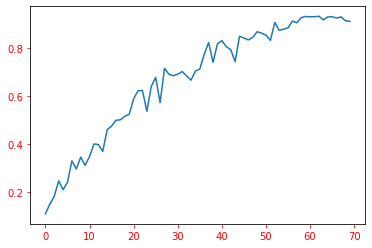

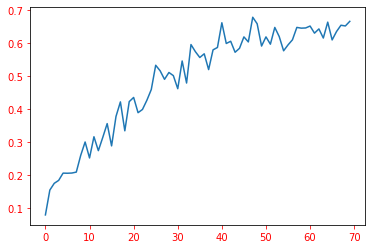

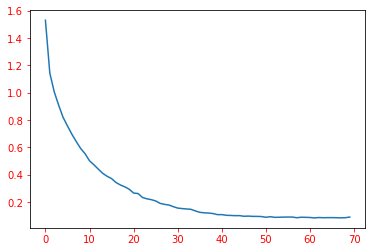

In [19]:
print_result(encoder1, decoder1,True)
show(loss_list, result1, result2)

# Teacher forcing:0.4, hidden_size=256, layer=2, lr=0.05,epochs:70

In [13]:
hidden_size = 256
encoder2 = EncoderLSTM(vocab_size, hidden_size, 2).to(device)
decoder2 = DecoderLSTM(hidden_size, vocab_size, 2).to(device)
loss_list, result1, result2 = trainIters(encoder2, decoder2, 12925, print_every=100,epochs=70)

epoch : 0


/tmp/ipykernel_120279/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_120279/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])


6m 52s (- 0m 0s) (12900 99%) 1.31633
test:
	score : 0.10980296734080915
	acc : 0.0

new_test:
	score : 0.07812694195794177
	acc : 0.0
--------------------------------------------------
epoch : 1
6m 58s (- 0m 0s) (12900 99%) 0.97143
test:
	score : 0.1507293440015865
	acc : 0.0

new_test:
	score : 0.15362377314109593
	acc : 0.04
--------------------------------------------------
epoch : 2
7m 0s (- 0m 0s) (12900 99%) 0.816476
test:
	score : 0.18247161797116798
	acc : 0.0

new_test:
	score : 0.1741310000862112
	acc : 0.04
--------------------------------------------------
epoch : 3
7m 0s (- 0m 0s) (12900 99%) 0.716058
test:
	score : 0.2473192674654949
	acc : 0.0

new_test:
	score : 0.1830464899164111
	acc : 0.06
--------------------------------------------------
epoch : 4
7m 1s (- 0m 0s) (12900 99%) 0.725788
test:
	score : 0.21071654158985878
	acc : 0.0

new_test:
	score : 0.20513095096734965
	acc : 0.04
--------------------------------------------------
epoch : 5
5m 47s (- 0m 0s) (12900 9

/tmp/ipykernel_120279/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_120279/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])



test:
	score : 0.9113410842201142
	acc : 0.88

new_test:
	score : 0.6665272507186889
	acc : 0.52
--------------------------------------------------


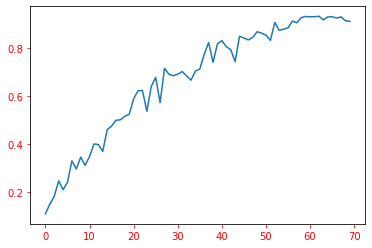

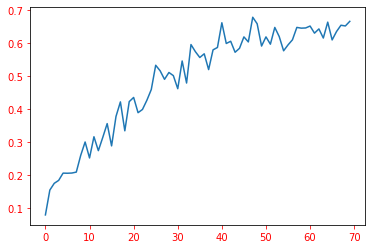

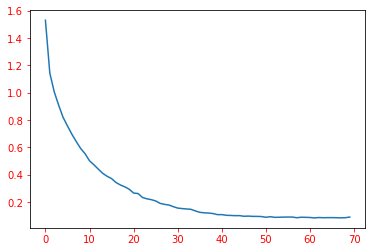

In [14]:
print_result(encoder2, decoder2)
show(loss_list, result1, result2)

# Teacher forcing:0.4, hidden_size=256, layer=1, lr=0.01,epochs:80

In [12]:
hidden_size = 256
encoder3 = EncoderLSTM(vocab_size, hidden_size, 1).to(device)
decoder3 = DecoderLSTM(hidden_size, vocab_size, 1).to(device)
loss_list, result1, result2 = trainIters(encoder3, decoder3, 12925, print_every=100,epochs=80)

epoch : 0


/tmp/ipykernel_149195/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_149195/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])


5m 22s (- 0m 0s) (12900 99%) 1.26938
test:
	score : 0.1136760973816788
	acc : 0.0

new_test:
	score : 0.08854994090314236
	acc : 0.0
--------------------------------------------------
epoch : 1
5m 53s (- 0m 0s) (12900 99%) 1.09988
test:
	score : 0.14514297537257842
	acc : 0.0

new_test:
	score : 0.13335946223406325
	acc : 0.0
--------------------------------------------------
epoch : 2
5m 40s (- 0m 0s) (12900 99%) 1.03437
test:
	score : 0.1500391728886556
	acc : 0.0

new_test:
	score : 0.1854721049016549
	acc : 0.02
--------------------------------------------------
epoch : 3
5m 29s (- 0m 0s) (12900 99%) 0.93125
test:
	score : 0.18244255519907207
	acc : 0.0

new_test:
	score : 0.18398872332432437
	acc : 0.02
--------------------------------------------------
epoch : 4
5m 54s (- 0m 0s) (12900 99%) 0.85864
test:
	score : 0.21727208970548717
	acc : 0.0

new_test:
	score : 0.2601490806252755
	acc : 0.06
--------------------------------------------------
epoch : 5
5m 54s (- 0m 0s) (12900 99

/tmp/ipykernel_149195/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_149195/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])



test:
	score : 0.9054896899393277
	acc : 0.86
input:  contenpted
target: contented
pred:   continted
input:  begining
target: beginning
pred:   beokining
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   rariage
input:  poartry
target: poetry
pred:   poetry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  

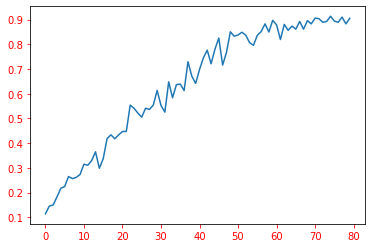

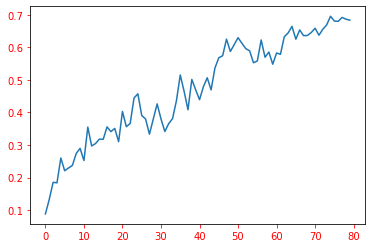

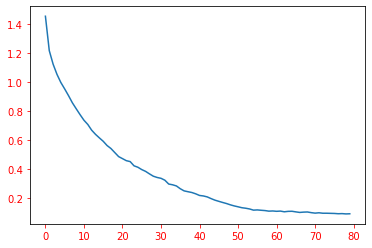

In [18]:
print_result(encoder3, decoder3,True)
show(loss_list, result1, result2)

# Teacher forcing:1, hidden_size=512, layer=5, lr=0.01,epochs:80

In [ ]:
hidden_size = 512
teacher_forcing_ratio = 1
encoder4 = EncoderLSTM(vocab_size, hidden_size).to(device)
decoder4 = DecoderLSTM(hidden_size, vocab_size).to(device)
loss_list, result1, result2 = trainIters(encoder4, decoder4, 12925, print_every=100,epochs=80)

epoch : 0


/tmp/ipykernel_149195/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_149195/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])


9m 15s (- 0m 1s) (12900 99%) 2.11323
test:
	score : 0.04509881203727503
	acc : 0.0

new_test:
	score : 0.060007050841752625
	acc : 0.0
--------------------------------------------------
epoch : 1
9m 4s (- 0m 1s) (12900 99%) 1.908660
test:
	score : 0.05220994108327798
	acc : 0.0

new_test:
	score : 0.047881143312395534
	acc : 0.0
--------------------------------------------------
epoch : 2
9m 13s (- 0m 1s) (12900 99%) 1.26958
test:
	score : 0.09082811167807245
	acc : 0.0

new_test:
	score : 0.0707771443847262
	acc : 0.0
--------------------------------------------------
epoch : 3
9m 18s (- 0m 1s) (12900 99%) 0.91578
test:
	score : 0.12757891997071663
	acc : 0.0

new_test:
	score : 0.12046946602833948
	acc : 0.02
--------------------------------------------------
epoch : 4
8m 40s (- 0m 1s) (12900 99%) 0.70092
test:
	score : 0.1877482688099667
	acc : 0.0

new_test:
	score : 0.14989451475304716
	acc : 0.04
--------------------------------------------------
epoch : 5
9m 6s (- 0m 1s) (12900 

/tmp/ipykernel_149195/2861193381.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])
/tmp/ipykernel_149195/2861193381.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ans = t.new_tensor(word_embedded[0])



test:
	score : 0.9247835333027635
	acc : 0.9
input:  contenpted
target: contented
pred:   contented
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juse
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   portry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  s

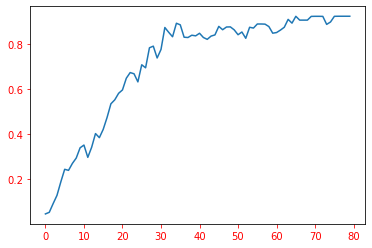

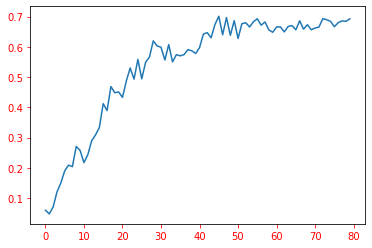

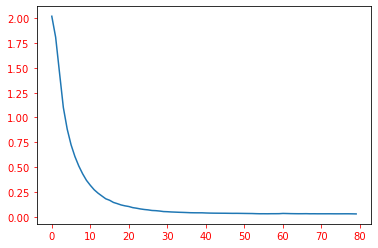

In [21]:
print_result(encoder4, decoder4,True)
show(loss_list, result1, result2)

In [ ]:
# SOS_token = 0
# EOS_token = 1
# #----------Hyper Parameters----------#
# hidden_size = 256
# #The number of vocabulary
# vocab_size = 29
# teacher_forcing_ratio = 1.0
# LR = 0.05
#
#
# myEncoder = EncoderLSTM(input_size=vocab_size, hidden_size=hidden_size).to(device)
# myDecoder = DecoderLSTM(hidden_size=hidden_size, output_size=vocab_size).to(device)
#
# dataset = myDataLoader('./dataset/A3_data/train.json')
# oneData = next(iter(dataset))
# encoder_hidden = myEncoder.initHidden()
# encoder_outputs = torch.zeros(len(oneData[0].to(device)), myEncoder.hidden_size, device=device)
# encoder_outputs, encoder_hidden= myEncoder(oneData[0], encoder_hidden)
#
# #print(encoder_hidden.shape)
# loss = 0
# decoder_hidden = encoder_hidden
# decoder_input = torch.tensor([[SOS_token]], device=device)
# criterion = nn.CrossEntropyLoss()
# for di in range(len(oneData[1])):
#     decoder_output, decoder_hidden = myDecoder(
#         decoder_input, decoder_hidden)
#
#     #print(decoder_output.squeeze())
#     # print(oneData[1][di])
#     # print(decoder_output.shape)
#     label = myOneHot(oneData[1][di])
#     #print(oneData[1][di])
#     loss += criterion(decoder_output, label)
#     decoder_input = oneData[1][di]  # Teacher forcing